In [6]:
from pathlib import Path
from datatools.fixture import setup_dummy_data

source = "./tool-tracking-data/"

In [7]:
from datatools import MeasurementDataReader, Measurement, MeasurementSeries, Action
mdr = MeasurementDataReader(source=source)

In [8]:
from datatools import Tool, Config, MeasurementSeries, Measurement, DataTypes, Action

# mytool = "electric_screwdriver"
mytool = "pneumatic_screwdriver"
# mytool = "pneumatic_rivet_gun"

In [9]:
import numpy as np
from seglearn.base import TS_Data
from seglearn.pipe import Pype
from fhgutils import Segment, contextual_recarray_dtype, filter_ts_data
from datatools import to_ts_data

In [10]:
window_length=0.4 # unit in s
overlap = 0.5 # unit in percent

# clean and window data
data_dict = mdr.query().filter_by(Tool == mytool).get()
Xt, Xc, y = to_ts_data(data_dict, contextual_recarray_dtype)

X = TS_Data(Xt, Xc)
pipe = Pype([
    ('segment', Segment(window_length=window_length, overlap=overlap, enforce_size=True, n=len(np.unique(Xc.desc))))
])

print('###############################################')
print("Number of sequences:", len(X.ts_data))
for i, seq in enumerate(X.ts_data):
    print(f"Sequence {i}: Type = {type(seq)}, Shape = {np.shape(seq)}")


X_trans, y_trans = pipe.fit_transform(X, y)

[INFO] Preparing data from:
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724


[INFO] Read annotation: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, file=data-04.annotation]


[INFO] Finished with 4 measurement(s).
###############################################
Number of sequences: 16
Sequence 0: Type = <class 'numpy.ndarray'>, Shape = (34271, 4)
Sequence 1: Type = <class 'numpy.ndarray'>, Shape = (34271, 4)
Sequence 2: Type = <class 'numpy.ndarray'>, Shape = (51930, 4)
Sequence 3: Type = <class 'numpy.ndarray'>, Shape = (2680320, 2)
Sequence 4: Type = <class 'numpy.ndarray'>, Shape = (36314, 4)
Sequence 5: Type = <class 'numpy.ndarray'>, Shape = (36314, 4)
Sequence 6: Type = <class 'numpy.ndarray'>, Shape = (55093, 4)
Sequence 7: Type = <class 'numpy.ndarray'>, Shape = (2840000, 2)
Sequence 8: Type = <class 'numpy.ndarray'>, Shape = (29631, 4)
Sequence 9: Type = <class 'numpy.ndarray'>, Shape = (29631, 4)
Sequence 10: Type = <class 'numpy.ndarray'>, Shape = (44848, 4)
Sequence 11: Type = <class 'numpy.ndarray'>, Shape = (2317440, 2)
Sequence 12: Type = <class 'numpy.ndarray'>, Shape = (27080, 4)
Sequence 13: Type = <class 'numpy.ndarray'>, Shape = (27080, 

In [11]:
# Remove the microphone channel

print("[INFO] extract segmented ACC data")
Xt_acc, Xc_acc, y_acc = filter_ts_data(X_trans, y_trans, filt={'desc': ['acc']})

print("[INFO] extract segmented GYR data")
Xt_gyr, Xc_gyr, y_gyr = filter_ts_data(X_trans, y_trans, filt={'desc': ['gyr']})

print("[INFO] extract segmented MAG data")
Xt_mag, Xc_mag, y_mag = filter_ts_data(X_trans, y_trans, filt={'desc': ['mag']})

print("[INFO] extract segmented MIC data")
Xt_mic, Xc_mic, y_mic = filter_ts_data(X_trans, y_trans, filt={'desc': ['mic']})


[INFO] extract segmented ACC data
[INFO] extract segmented GYR data
[INFO] extract segmented MAG data
[INFO] extract segmented MIC data


In [12]:
print("[INFO] shape of ACC data is", Xt_acc.shape)
print("[INFO] shape of GYR data is", Xt_gyr.shape)
print("[INFO] shape of MAG data is", Xt_mag.shape)
print("[INFO] shape of MIC data is", Xt_mic.shape)
print(f"[INFO] {Xt_gyr.shape[0]} windows with {Xt_gyr[0].shape[0]} sample each (time stamps and 3 axis gyroscope)")
print(f"[INFO] {Xt_acc.shape[0]} windows with {Xt_acc[0].shape[0]} sample each (time stamps and 3 axis accelerometer)")
print(f"[INFO] {Xt_mag.shape[0]} windows with {Xt_mag[0].shape[0]} sample each (time stamps and 3 axis magnetometer)")
print(f"[INFO] {Xt_mic.shape[0]} windows with {Xt_mic[0].shape[0]} sample each (time stamps and 1 axis microphone)")

[INFO] shape of ACC data is (6217,)
[INFO] shape of GYR data is (6217,)
[INFO] shape of MAG data is (6217,)
[INFO] shape of MIC data is (6217,)
[INFO] 6217 windows with 41 sample each (time stamps and 3 axis gyroscope)
[INFO] 6217 windows with 41 sample each (time stamps and 3 axis accelerometer)
[INFO] 6217 windows with 62 sample each (time stamps and 3 axis magnetometer)
[INFO] 6217 windows with 3200 sample each (time stamps and 1 axis microphone)


In [13]:
from fhgutils import filter_labels, one_label_per_window
from data_preprocessing import find_ambiguous_windows,remove_windows_by_indices

In [14]:
ambiguous_acc = find_ambiguous_windows(Xt_acc, Xc_acc, y_acc, name="ACC")
ambiguous_gyr = find_ambiguous_windows(Xt_gyr, Xc_gyr, y_gyr, name="GYR")
ambiguous_mag = find_ambiguous_windows(Xt_mag, Xc_mag, y_mag, name="MAG")
ambiguous_mic = find_ambiguous_windows(Xt_mic, Xc_mic, y_mic, name="MIC")

# Union of all ambiguous window indices - windows with no majority label
ambiguous_indices = set(ambiguous_acc) | set(ambiguous_gyr) | set(ambiguous_mag) | set(ambiguous_mic)

print(f"Number of all ambiguous window indices across 4 modalities: {len(ambiguous_indices)}")


[ACC] Checking for ambiguous windows...
[ACC] Found 0 ambiguous windows.
[GYR] Checking for ambiguous windows...
[GYR] Found 0 ambiguous windows.
[MAG] Checking for ambiguous windows...
[MAG] Found 73 ambiguous windows.
[MIC] Checking for ambiguous windows...
[MIC] Found 34 ambiguous windows.
Number of all ambiguous window indices across 4 modalities: 84


In [15]:
# To remove windows without majority label from all modalities
Xt_acc_f, Xc_acc_f, y_acc_f = remove_windows_by_indices(Xt_acc, Xc_acc, y_acc, ambiguous_indices)
Xt_gyr_f, Xc_gyr_f, y_gyr_f = remove_windows_by_indices(Xt_gyr, Xc_gyr, y_gyr, ambiguous_indices)
Xt_mag_f, Xc_mag_f, y_mag_f = remove_windows_by_indices(Xt_mag, Xc_mag, y_mag, ambiguous_indices)
Xt_mic_f, Xc_mic_f, y_mic_f = remove_windows_by_indices(Xt_mic, Xc_mic, y_mic, ambiguous_indices)

# Code to print the window incase of unequal samples per window, eg: incase MIC data for pneumatic screw driver
for k in range(len(y_mic_f)):
    for i in y_mic_f[k]:
        if i == -42:
            print(k)

[INFO] Xt shape: (6133,)
[INFO] y shape after processing: (6133, 41)
[INFO] Xt shape: (6133,)
[INFO] y shape after processing: (6133, 41)
[INFO] Xt shape: (6133,)
[INFO] y shape after processing: (6133, 62)
[INFO] Xt shape: (6133,)
[INFO] y shape after processing: (6133, 3200)
5495


In [16]:
y_acc_f = one_label_per_window(y_acc_f)
y_gyr_f = one_label_per_window(y_gyr_f)
y_mag_f = one_label_per_window(y_mag_f)
y_mic_f = one_label_per_window(y_mic_f)
# Print y_mic_f
print("-----------------------------------------------")
print(f"[ACC] Number of windows after removing ambiguous window indices: {len(y_acc_f)}")
print(f"[GYR] Number of windows after removing ambiguous window indices: {len(y_gyr_f)}")
print(f"[MAG] Number of windows after removing ambiguous window indices: {len(y_mag_f)}")
print(f"[MIC] Number of windows after removing ambiguous window indices: {len(y_mic_f)}")




Below find the number of unique labels in the data
flattened 9 labels: [-1  2  3  4  5  7  8 14 38]
Below find the number of unique labels in the data
flattened 9 labels: [-1  2  3  4  5  7  8 14 38]
Below find the number of unique labels in the data
flattened 9 labels: [-1  2  3  4  5  7  8 14 38]
Below find the number of unique labels in the data
flattened 9 labels: [-1  2  3  4  5  7  8 14 38]
-----------------------------------------------
[ACC] Number of windows after removing ambiguous window indices: 6133
[GYR] Number of windows after removing ambiguous window indices: 6133
[MAG] Number of windows after removing ambiguous window indices: 6133
[MIC] Number of windows after removing ambiguous window indices: 6133


In [17]:
inconsistent_indices = [
    i for i in range(len(y_acc_f))
    if not (y_acc_f[i] == y_gyr_f[i] == y_mag_f[i] == y_mic_f[i])
]
print(f"The number of mismatched windows before removing across 4 modalities: {len(inconsistent_indices)}")

Xt_acc_f, Xc_acc_f, y_acc_f = remove_windows_by_indices(Xt_acc_f, Xc_acc_f, y_acc_f, inconsistent_indices)
Xt_gyr_f, Xc_gyr_f, y_gyr_f = remove_windows_by_indices(Xt_gyr_f, Xc_gyr_f, y_gyr_f, inconsistent_indices)
Xt_mag_f, Xc_mag_f, y_mag_f = remove_windows_by_indices(Xt_mag_f, Xc_mag_f, y_mag_f, inconsistent_indices)
Xt_mic_f, Xc_mic_f, y_mic_f = remove_windows_by_indices(Xt_mic_f, Xc_mic_f, y_mic_f, inconsistent_indices)

inconsistent_indices = [
    i for i in range(len(y_acc_f))
    if not (y_acc_f[i] == y_gyr_f[i] == y_mag_f[i] == y_mic_f[i])
]
print(f"The number of mismatched windows after removing across 4 modalities (should be zero): {len(inconsistent_indices)}")

print("-----------------------------------------------")
print(f"[ACC] Number of windows after removing mismatched window indices: {len(y_acc_f)}")
print(f"[GYR] Number of windows after removing mismatched window indices: {len(y_gyr_f)}")
print(f"[MAG] Number of windows after removing mismatched window indices: {len(y_mag_f)}")
print(f"[MIC] Number of windows after removing mismatched window indices: {len(y_mic_f)}")

print(y_mic_f[5568])


The number of mismatched windows before removing across 4 modalities: 9
[INFO] Xt shape: (6124,)
[INFO] y shape after processing: (6124,)
[INFO] Xt shape: (6124,)
[INFO] y shape after processing: (6124,)
[INFO] Xt shape: (6124,)
[INFO] y shape after processing: (6124,)
[INFO] Xt shape: (6124,)
[INFO] y shape after processing: (6124,)
The number of mismatched windows after removing across 4 modalities (should be zero): 0
-----------------------------------------------
[ACC] Number of windows after removing mismatched window indices: 6124
[GYR] Number of windows after removing mismatched window indices: 6124
[MAG] Number of windows after removing mismatched window indices: 6124
[MIC] Number of windows after removing mismatched window indices: 6124
8


In [18]:
# import pandas as pd
# from datetime import datetime, timezone

# # Function to format timestamp as a readable string
# def format_timestamp(ts):
#     return datetime.fromtimestamp(ts, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]

# # Collect data for all windows
# window_data = []

# for i in range(len(Xt_acc_f)):
#     start_ts = Xt_acc_f[i][0][0]
#     end_ts = Xt_acc_f[i][-1][0]
#     duration = end_ts - start_ts

#     window_data.append({
#         "Window": i,
#         "Start_Timestamp": start_ts,
#         "End_Timestamp": end_ts,
#         "Start_Time_UTC": format_timestamp(start_ts),
#         "End_Time_UTC": format_timestamp(end_ts),
#         "Duration_sec": round(duration, 4),
#         "label": y_acc_f[i]
#     })

# # Create DataFrame and save to CSV
# df = pd.DataFrame(window_data)
# csv_path = "filtered_accelerometer_window_times.csv"
# df.to_csv(csv_path, index=False)

# print(f"[INFO] Saved window timestamp data to {csv_path}")


In [19]:
# To get the unique lables and their counts

# For Accelerometer
unique_acc, counts_acc = np.unique(y_acc_f, return_counts=True)
print("[ACC] Unique labels and their counts:")
for label, count in zip(unique_acc, counts_acc):
    print(f"  Label: {label}, Count: {count}")

# For Gyroscope
unique_gyr, counts_gyr = np.unique(y_gyr_f, return_counts=True)
print("[GYR] Unique labels and their counts:")
for label, count in zip(unique_gyr, counts_gyr):
    print(f"  Label: {label}, Count: {count}")

# For Magnetometer
unique_mag, counts_mag = np.unique(y_mag_f, return_counts=True)
print("[MAG] Unique labels and their counts:")
for label, count in zip(unique_mag, counts_mag):
    print(f"  Label: {label}, Count: {count}")

# For Microphone
unique_mic, counts_mic = np.unique(y_mic_f, return_counts=True)
print("[MIC] Unique labels and their counts:")
for label, count in zip(unique_mic, counts_mic):
    print(f"  Label: {label}, Count: {count}")


[ACC] Unique labels and their counts:
  Label: -1, Count: 15
  Label: 2, Count: 307
  Label: 3, Count: 296
  Label: 4, Count: 64
  Label: 5, Count: 44
  Label: 7, Count: 98
  Label: 8, Count: 5199
  Label: 14, Count: 64
  Label: 38, Count: 37
[GYR] Unique labels and their counts:
  Label: -1, Count: 15
  Label: 2, Count: 307
  Label: 3, Count: 296
  Label: 4, Count: 64
  Label: 5, Count: 44
  Label: 7, Count: 98
  Label: 8, Count: 5199
  Label: 14, Count: 64
  Label: 38, Count: 37
[MAG] Unique labels and their counts:
  Label: -1, Count: 15
  Label: 2, Count: 307
  Label: 3, Count: 296
  Label: 4, Count: 64
  Label: 5, Count: 44
  Label: 7, Count: 98
  Label: 8, Count: 5199
  Label: 14, Count: 64
  Label: 38, Count: 37
[MIC] Unique labels and their counts:
  Label: -1, Count: 15
  Label: 2, Count: 307
  Label: 3, Count: 296
  Label: 4, Count: 64
  Label: 5, Count: 44
  Label: 7, Count: 98
  Label: 8, Count: 5199
  Label: 14, Count: 64
  Label: 38, Count: 37


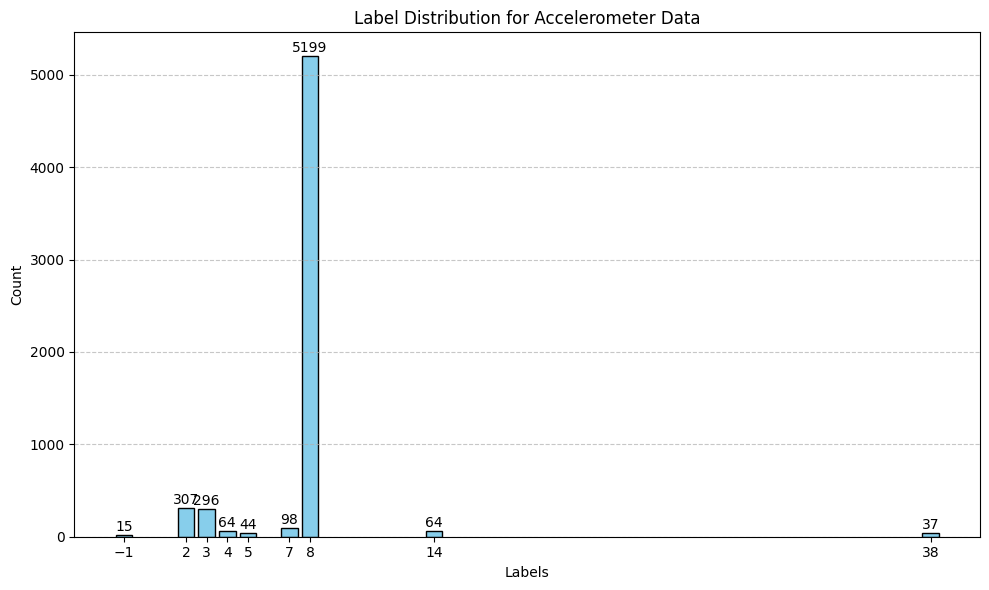

In [20]:
# Plot label distribution

import matplotlib.pyplot as plt

# Get unique labels and their counts
unique_labels, counts = np.unique(y_acc_f, return_counts=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_labels, counts, color='skyblue', edgecolor='black')

# Add annotations (counts) above each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(count), 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution for Accelerometer Data')
plt.xticks(unique_labels)  # ensure all labels are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [21]:
# Verify that the number of windows and window length are consistent
print(f"[INFO] {Xt_acc_f.shape[0]} windows with {Xt_acc_f[0].shape[0]} sample each (time stamps and 3 axis accelerometer)")
print(f"[INFO] {Xt_gyr_f.shape[0]} windows with {Xt_gyr_f[0].shape[0]} sample each (time stamps and 3 axis gyroscope)")
print(f"[INFO] {Xt_mag_f.shape[0]} windows with {Xt_mag_f[0].shape[0]} sample each (time stamps and 3 axis magnetometer)")
print(f"[INFO] {Xt_mic_f.shape[0]} windows with {Xt_mic_f[0].shape[0]} sample each (time stamps and 1 axis microphone)")

# assert Xt_acc_f.shape[0] == Xt_gyr_f.shape[0] == Xt_mag_f.shape[0], "Number of windows is not equal"


[INFO] 6124 windows with 41 sample each (time stamps and 3 axis accelerometer)
[INFO] 6124 windows with 41 sample each (time stamps and 3 axis gyroscope)
[INFO] 6124 windows with 62 sample each (time stamps and 3 axis magnetometer)
[INFO] 6124 windows with 3200 sample each (time stamps and 1 axis microphone)


Code: Interpolation + Timestamp-aligned Downsampling

In [22]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import resample

# Assuming Xt_acc_f, Xt_gyr_f, Xt_mag_f, Xt_mic_f, y_acc_f are already loaded

# Determine the number of usable windows
num_windows = min(Xt_acc_f.shape[0], Xt_gyr_f.shape[0], Xt_mag_f.shape[0], Xt_mic_f.shape[0])
Xt_acc_f = Xt_acc_f[:num_windows]
Xt_gyr_f = Xt_gyr_f[:num_windows]
Xt_mag_f = Xt_mag_f[:num_windows]
Xt_mic_f = Xt_mic_f[:num_windows]
y_filtered = y_acc_f[:num_windows]

print(num_windows)

combined_data = []
combined_labels = []

target_length = 41  # downsample target

for i in range(num_windows):
    # Extract timestamps and values
    time_acc = Xt_acc_f[i][:, 0]
    acc_values = Xt_acc_f[i][:, 1:]

    time_gyr = Xt_gyr_f[i][:, 0]
    gyr_values = Xt_gyr_f[i][:, 1:]

    time_mag = Xt_mag_f[i][:, 0]
    mag_values = Xt_mag_f[i][:, 1:]

    time_mic = Xt_mic_f[i][:, 0]
    mic_values = Xt_mic_f[i][:, 1]

    # Use accelerometer timestamps as the reference time grid
    reference_time = time_acc

    # Interpolate each sensor to match the accelerometer's timestamps
    def safe_interp(original_time, values, target_time, num_axes=1):
        try:
            if num_axes == 1:
                f = interp1d(original_time, values, bounds_error=False, fill_value="extrapolate")
                return f(target_time).reshape(-1, 1)
            else:
                return np.stack([
                    interp1d(original_time, values[:, j], bounds_error=False, fill_value="extrapolate")(target_time)
                    for j in range(num_axes)
                ], axis=-1)
        except Exception as e:
            print(f"[WARN] Interpolation failed at window {i}: {e}")
            return np.full((len(target_time), num_axes), np.nan)

    acc_interp = acc_values  # already aligned
    gyr_interp = safe_interp(time_gyr, gyr_values, reference_time, 3)
    mag_interp = safe_interp(time_mag, mag_values, reference_time, 3)
    mic_interp = safe_interp(time_mic, mic_values, reference_time, 1)

    # Combine everything into one aligned signal: [t, acc, gyr, mag, mic]
    aligned = np.concatenate([
        reference_time.reshape(-1, 1),  # shape: (41, 1)
        acc_interp,
        gyr_interp,
        mag_interp,
        mic_interp
    ], axis=1)  # shape: (41, 11)

    # Downsample the aligned signal to target_length (still 41 in our case)
    aligned_downsampled = resample(aligned, target_length, axis=0)

    combined_data.append(aligned_downsampled)
    combined_labels.append(y_filtered[i])

# Final arrays
combined_data = np.array(combined_data)       # shape: (num_windows, 41, 11)
combined_labels = np.array(combined_labels)   # shape: (num_windows,)

print("[INFO] Combined data shape:", combined_data.shape)
print("[INFO] Combined label shape:", combined_labels.shape)
print("[INFO] Example entry (first window, first time step):", combined_data[0][0])


6124
[INFO] Combined data shape: (6124, 41, 11)
[INFO] Combined label shape: (6124,)
[INFO] Example entry (first window, first time step): [ 1.59422590e+09 -8.18138700e+00 -1.32684100e+00  5.36963400e+00
  3.83495200e-02  4.79369000e-02 -3.30232000e-02  3.02838375e-05
  3.56115079e-05 -7.46967464e-05 -9.00000000e+00]


### Code with Downsampling to 41 Samples

In [23]:
from scipy.signal import resample

# Assuming Xt_acc_f, Xt_gyr_f (7259 × 41),
# Xt_mag_f (7219 × 62), Xt_mic_f (7185 × 3200), and y_acc_f are loaded

# Trim all datasets to the smallest common window count
num_windows = min(Xt_acc_f.shape[0], Xt_gyr_f.shape[0], Xt_mag_f.shape[0], Xt_mic_f.shape[0])
Xt_acc_f = Xt_acc_f[:num_windows]
Xt_gyr_f = Xt_gyr_f[:num_windows]
Xt_mag_f = Xt_mag_f[:num_windows]
Xt_mic_f = Xt_mic_f[:num_windows]
y_filtered = y_acc_f[:num_windows]

combined_data = []
combined_labels = []
target_length = 41  # downsample everything to 41 samples

for i in range(num_windows):
    # Separate timestamps and values
    time_acc = Xt_acc_f[i][:, 0]
    acc_values = Xt_acc_f[i][:, 1:]  # shape: (41, 3)

    time_gyr = Xt_gyr_f[i][:, 0]
    gyr_values = Xt_gyr_f[i][:, 1:]  # shape: (41, 3)

    time_mag = Xt_mag_f[i][:, 0]
    mag_values = Xt_mag_f[i][:, 1:]  # shape: (62, 3)

    time_mic = Xt_mic_f[i][:, 0]
    mic_values = Xt_mic_f[i][:, 1]   # shape: (3200,)

    # Downsample magnetometer to 41 samples
    mag_downsampled = resample(mag_values, target_length)

    # Downsample microphone to 41 samples (keep as (41, 1))
    mic_downsampled = resample(mic_values, target_length).reshape(-1, 1)

    # Use accelerometer timestamps as the unified time vector
    new_time = time_acc.reshape(-1, 1)

    # Combine all features (shape: 41 × (1 + 3 + 3 + 3 + 1) = 41 × 11)
    combined_features = np.concatenate(
        (new_time, acc_values, gyr_values, mag_downsampled, mic_downsampled),
        axis=1
    )
    combined_data.append(combined_features)
    combined_labels.append(y_filtered[i])

# Final array shapes
combined_data = np.array(combined_data)       # shape: (num_windows, 41, 11)
combined_labels = np.array(combined_labels)   # shape: (num_windows,)

In [24]:
print("[INFO] Shape of combined data:", combined_data.shape)
print("[INFO] Shape of combined labels:", combined_labels.shape)
print("[INFO] Feature example (first window, first step):", combined_data[0][0])
print("[INFO] First label:", combined_labels[0])

[INFO] Shape of combined data: (6124, 41, 11)
[INFO] Shape of combined labels: (6124,)
[INFO] Feature example (first window, first step): [ 1.59422590e+09 -8.18138700e+00 -1.32684100e+00  5.36963400e+00
  3.83495200e-02  4.79369000e-02 -3.30232000e-02  2.93940573e-05
  3.51516915e-05 -7.44981891e-05 -5.56356082e+00]
[INFO] First label: 8


## Code for upsampling

In [25]:
import numpy as np
from scipy.interpolate import interp1d

# Assuming Xt_acc_f, Xt_gyr_f (number of windows >= 7219, 41 samples),
# Xt_mag_f (7219 windows, 62 samples), and y_acc_f (number of windows >= 7219) are loaded

num_windows = min(Xt_acc_f.shape[0], Xt_gyr_f.shape[0], Xt_mag_f.shape[0])
Xt_acc_f = Xt_acc_f[:num_windows]
Xt_gyr_f = Xt_gyr_f[:num_windows]
Xt_mag_f = Xt_mag_f[:num_windows]
y_filtered = y_acc_f[:num_windows] # Assuming y_acc_f is the correct label set

combined_data = []
combined_labels = []
target_length = 62

for i in range(num_windows):
    time_acc = Xt_acc_f[i][:, 0]
    acc_values = Xt_acc_f[i][:, 1:]
    time_gyr = Xt_gyr_f[i][:, 0]
    gyr_values = Xt_gyr_f[i][:, 1:]
    time_mag = Xt_mag_f[i][:, 0]
    mag_values = Xt_mag_f[i][:, 1:]

    # Create interpolation functions for each sensor axis
    interp_acc = [interp1d(time_acc, acc_values[:, j], fill_value="extrapolate") for j in range(3)]
    interp_gyr = [interp1d(time_gyr, gyr_values[:, j], fill_value="extrapolate") for j in range(3)]
    interp_mag = [interp1d(time_mag, mag_values[:, j], fill_value="extrapolate") for j in range(3)]

    # Create a new time vector of the target length (using the time range of the longest sequence)
    start_time = min(time_acc[0], time_gyr[0], time_mag[0])
    end_time = max(time_acc[-1], time_gyr[-1], time_mag[-1])
    new_time = np.linspace(start_time, end_time, target_length)

    # Interpolate the sensor values at the new time points
    resampled_acc = np.array([interp_acc[j](new_time) for j in range(3)]).T
    resampled_gyr = np.array([interp_gyr[j](new_time) for j in range(3)]).T
    resampled_mag = np.array([interp_mag[j](new_time) for j in range(3)]).T

    # Combine the timestamp and resampled sensor data
    combined_features = np.concatenate((new_time[:, np.newaxis], resampled_acc, resampled_gyr, resampled_mag), axis=1)
    combined_data.append(combined_features)
    combined_labels.append(y_filtered[i])

combined_data = np.array(combined_data)
combined_labels = np.array(combined_labels)

print("[INFO] Shape of combined data:", combined_data.shape)
print("[INFO] Shape of combined labels:", combined_labels.shape)
print("[INFO] Example of combined data for the first window, first time step:")
print(combined_data[0][0])
print("[INFO] Example of the first combined label:")
print(combined_labels[0])

# Now you can proceed with splitting and scaling this combined_data

[INFO] Shape of combined data: (6124, 62, 10)
[INFO] Shape of combined labels: (6124,)
[INFO] Example of combined data for the first window, first time step:
[ 1.59422590e+09 -8.16385930e+00 -1.34252388e+00  5.36225391e+00
  3.79391992e-02  4.89627011e-02 -3.44593220e-02  3.03331400e-05
  3.57101100e-05 -7.44009400e-05]
[INFO] Example of the first combined label:
8


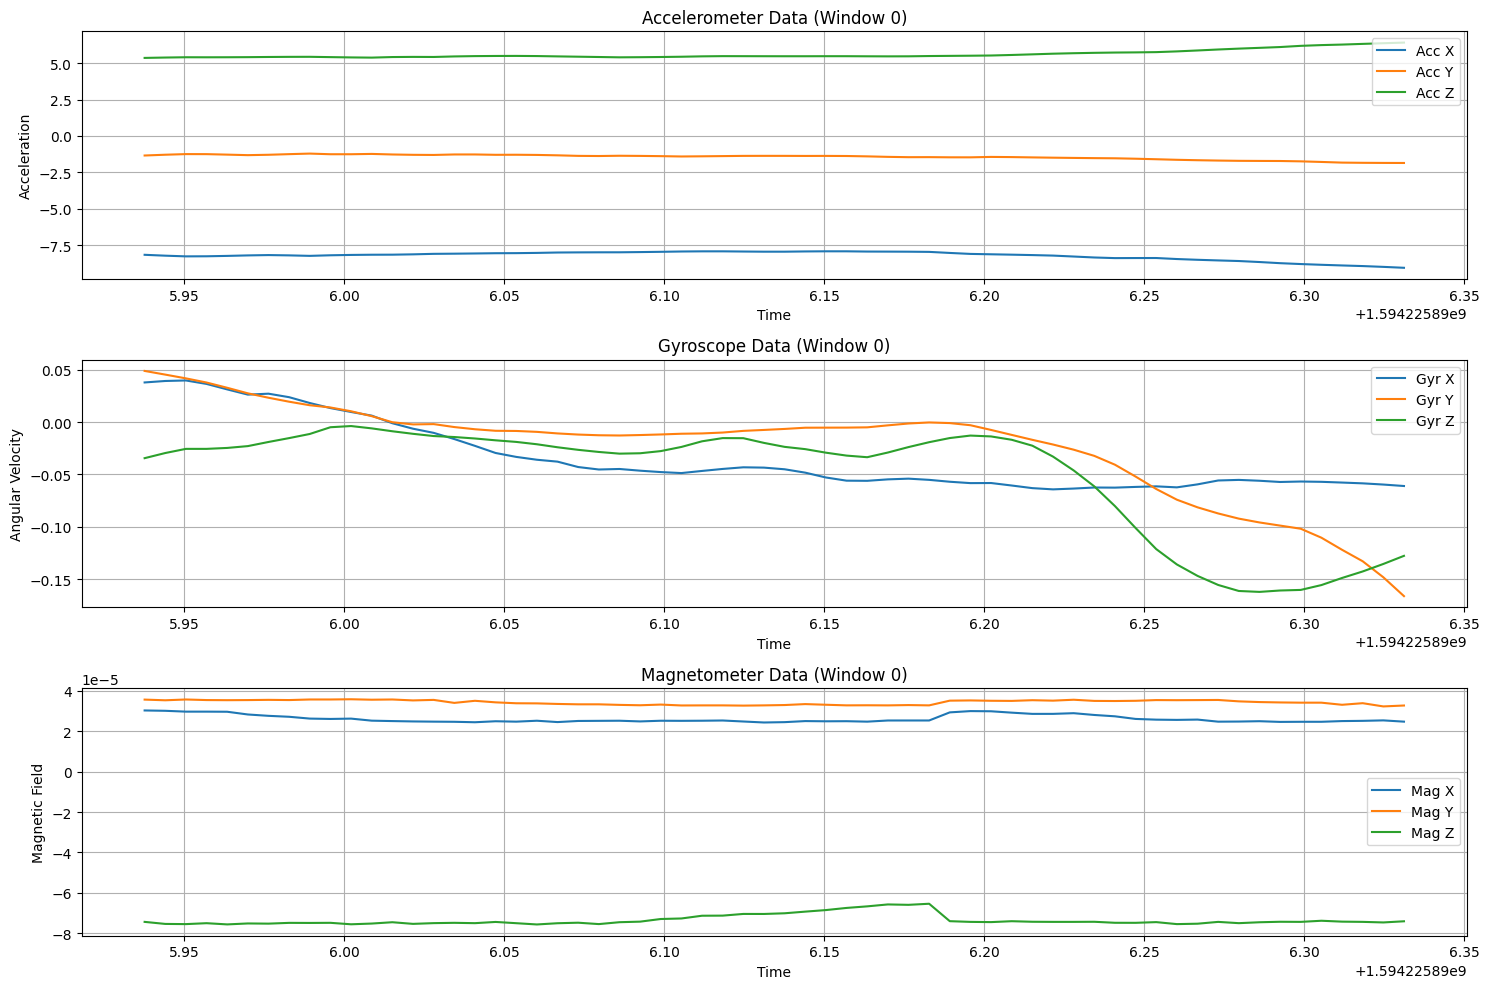

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'combined_data' is your NumPy array of shape (num_windows, time_steps, features)

# Select the first window
window_index = 0
time = combined_data[window_index][:, 0]
acc_x = combined_data[window_index][:, 1]
acc_y = combined_data[window_index][:, 2]
acc_z = combined_data[window_index][:, 3]
gyr_x = combined_data[window_index][:, 4]
gyr_y = combined_data[window_index][:, 5]
gyr_z = combined_data[window_index][:, 6]
mag_x = combined_data[window_index][:, 7]
mag_y = combined_data[window_index][:, 8]
mag_z = combined_data[window_index][:, 9]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(time, acc_x, label='Acc X')
plt.plot(time, acc_y, label='Acc Y')
plt.plot(time, acc_z, label='Acc Z')
plt.title(f'Accelerometer Data (Window {window_index})')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, gyr_x, label='Gyr X')
plt.plot(time, gyr_y, label='Gyr Y')
plt.plot(time, gyr_z, label='Gyr Z')
plt.title(f'Gyroscope Data (Window {window_index})')
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, mag_x, label='Mag X')
plt.plot(time, mag_y, label='Mag Y')
plt.plot(time, mag_z, label='Mag Z')
plt.title(f'Magnetometer Data (Window {window_index})')
plt.xlabel('Time')
plt.ylabel('Magnetic Field')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# You can also plot other windows by changing the 'window_index' variable